## EY Data Challenge - Landsat Land Surface Temperature

This sample notebook can be used to create a Landsat Land Surface Temperature (LST) product. The notebook creates a cloud-filtered median mosaic for any time period and location and then creates the LST product. A median mosaic reflects the "median" value of pixels for all spectral bands in the time series. When scenes within a time series contain clouds, the use of a median calculation can statistically remove clouds from the final median mosaic product, assuming there are plenty of clear pixels within the time series. The baseline data is [Landsat Collection-2 Level-2](https://www.usgs.gov/landsat-missions/landsat-collection-2) data from the MS Planetary Computer catalog.

In [24]:
!pip install rioxarray rasterio stackstac pystac_client planetary_computer odc.stac osmnx

In [25]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import jet,RdYlGn

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

### Discover and load the data for analysis

First, we define our area of interest using latitude and longitude coordinates.

In [26]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [27]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [28]:
# Define the time window
# We will use a period of 3 months to search for data
time_window = "2021-06-01/2021-09-01"

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. The query searches for "low cloud" scenes with overall cloud cover <20%. We will also limit our search to Landsat-8 to avoid the Landsat-7 scan line corrector failure. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes or contain clouds.

In [29]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["landsat-c2-l2"],
    query={"eo:cloud_cover": {"lt": 50},"platform": {"in": ["landsat-8"]}},
)

In [30]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 8


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/). We will only keep the commonly used spectral bands (Red, Green, Blue, NIR, Surface Temperature). There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 30-meters.

In [31]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [32]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 30  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326

### Landsat Band Summary 
The following list of bands will be loaded by the Open Data Cube (ODC) stac command:<br>
We will use two load commands to separate the RGB data from the Surface Temperature data.<br><br>
Band 2 = blue = 30m<br>
Band 3 = green = 30m<br>
Band 4 = red = 30m<br>
Band 5 = nir08 (near infrared) = 30m<br>
Band 11 = Surface Temperature = lwir11 = 100m

In [33]:
data1 = stac_load(
    items,
    bands=["red", "green", "blue", "nir08", "swir16", "swir22", "lwir11", "qa_pixel"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

Since the data matching our query isn't too large we can persist it in distributed memory. Once in memory, subsequent operations will be much faster.

In [34]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(data1)
# display(data2)

<xarray.Dataset> Size: 35MB
Dimensions:      (latitude: 484, longitude: 558, time: 8)
Coordinates:
  * latitude     (latitude) float64 4kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 4kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 64B 2021-06-07T15:39:15.904901 ... 202...
Data variables:
    red          (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    nir08        (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    swir16       (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    swir22       (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    lwir11       (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    qa_pixel     (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>

In [35]:
# Persist the data in memory for faster operations
data1 = data1.persist()
# data2 = data2.persist()

### Scaling Datasets
Landsat Collection-2 Level-2 products require scaling before creating valid output products. <br>
Scale factors for the RGB and NIR bands differ from scale factors for the Surface Temperature band.<br>

In [36]:
reflective_scale = 0.0000275
reflective_offset = -0.2
thermal_scale = 0.00341802
thermal_offset = 149.0
kelvin_to_celsius = 273.15

data1['red'] = data1['red'].astype(float) * reflective_scale + reflective_offset 
data1['green'] = data1['green'].astype(float) * reflective_scale + reflective_offset
data1["blue"] = data1["blue"].astype(float) * reflective_scale + reflective_offset
data1["nir08"] = data1["nir08"].astype(float) * reflective_scale + reflective_offset
data1["swir16"] = data1["swir16"].astype(float) * reflective_scale + reflective_offset
data1["swir22"] = data1["swir22"].astype(float) * reflective_scale + reflective_offset

data1["lwir11"] = data1["lwir11"].astype(float) * thermal_scale + thermal_offset - kelvin_to_celsius

In [37]:
# def create_cloud_mask(qa_pixel):
#     """
#     Create a cloud mask from the QA_PIXEL band of Landsat-8.
#     Cloud-related bits: 3, 4, 5, 6, 7.
#     """
#     cloud_mask = (
#         ((qa_pixel & (1 << 3)) == 0) &  # Cloud
#         ((qa_pixel & (1 << 4)) == 0) &  # Cloud Confidence (low)
#         ((qa_pixel & (1 << 5)) == 0) &  # Cloud Confidence (high)
#         ((qa_pixel & (1 << 6)) == 0) &  # Cirrus Cloud
#         ((qa_pixel & (1 << 7)) == 0)    # Cirrus Confidence (high)
#     )
#     return cloud_mask
def create_cloud_mask(qa_pixel):
    """
    Create a cloud mask from the QA_PIXEL band of Landsat-8.
    Adjusted to keep more valid data while still filtering strong clouds.
    """
    cloud_mask = (
        ((qa_pixel & (1 << 3)) == 0)#  &  ((qa_pixel & (1 << 6)) == 0)    # Cirrus Cloud - STRICT
    )
    return cloud_mask

# Apply the cloud mask
weights = create_cloud_mask(data1["qa_pixel"])
print(weights)

<xarray.DataArray 'qa_pixel' (time: 8, latitude: 484, longitude: 558)> Size: 2MB
dask.array<eq, shape=(8, 484, 558), dtype=bool, chunksize=(1, 484, 558), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 4kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 4kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 64B 2021-06-07T15:39:15.904901 ... 202...


In [38]:
# import numpy as np
# import xarray as xr
# import rioxarray
# from rasterio.transform import from_bounds
# import rasterio  # Added missing import
# from tqdm.auto import tqdm
# import os

# def create_weighted_mosaic(data1, weights, bounds, resolution_degrees=0.0003):
#     """
#     Creates a properly georeferenced weighted mosaic from Landsat data.
#     """
#     print("Creating weighted mosaic with proper georeferencing...")
    
#     min_lon, min_lat, max_lon, max_lat = bounds
    
#     # Correct coordinate generation using linspace
#     num_lons = int((max_lon - min_lon) / resolution_degrees) + 1
#     lons = np.linspace(min_lon, max_lon, num=num_lons)
#     num_lats = int((max_lat - min_lat) / resolution_degrees) + 1
#     lats = np.linspace(max_lat, min_lat, num=num_lats)
#     for band in tqdm(band_names):
#         if band == 'qa_pixel':  # Handle QA differently
#             # Use majority vote for QA
#             ds[band] = data1[band].mode(dim='time', keep_attrs=True)
#         else:
#             valid_data = (data1[band] * weights).where(data1[band].notnull())
#             weighted_sum = valid_data.sum(dim="time")
#             ds[band] = weighted_sum / valid_weights
    
#     total_weights = weights.sum(dim="time")
#     valid_weights = xr.where(total_weights > 0, total_weights, 1)
    
#     ds = xr.Dataset(coords={'latitude': lats, 'longitude': lons})
    
#     # Process bands and indices (unchanged)
#     # [Remainder of the function unchanged for brevity]
    
#     return ds

# def save_mosaic_to_tiff(ds, output_path, bounds):
#     """
#     Saves the mosaic dataset to GeoTIFF files with error handling.
#     """
#     output_dir = os.path.dirname(output_path)
#     if output_dir:
#         os.makedirs(output_dir, exist_ok=True)
    
#     base_name = os.path.splitext(os.path.basename(output_path))[0]
#     created_files = []
    
#     for var_name in ds.data_vars:
#         var_path = os.path.join(output_dir, f"{base_name}_{var_name}.tiff")
#         try:
#             da = ds[var_name]
#             da.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
#             da.rio.write_crs("EPSG:4326", inplace=True)
            
#             print(f"Saving {var_name} to: {var_path}")
#             da.rio.to_raster(
#                 var_path,
#                 driver="GTiff",
#                 dtype="float32",
#                 compress="lzw",
#                 nodata=np.nan
#             )
#             created_files.append(var_path)
#             print(f"Successfully saved {var_name}")
#         except Exception as e:
#             print(f"Error saving {var_name}: {str(e)}")
    
#     return created_files

# def verify_output_tiff(tiff_path):
#     """
#     Verifies the GeoTIFF file.
#     """
#     try:
#         with rasterio.open(tiff_path) as src:
#             # Verification checks (unchanged)
#             pass
#         return True
#     except Exception as e:
#         print(f"Verification error: {e}")
#         return False

# # Example Usage with Corrected Output Path
# bounds =  (lower_left[1], lower_left[0], upper_right[1], upper_right[0])  # Ensure correct order
# mosaic_ds = create_weighted_mosaic(data1, weights, bounds)
# output_path = "/kaggle/working/mosaic.tiff"  # Base filename

# # Save and get list of created files
# created_files = save_mosaic_to_tiff(mosaic_ds, output_path, bounds)

# # Verify the first created file
# if created_files:
#     verify_output_tiff(created_files[0])  # Check first band file
# else:
#     print("No files were created during export.")

In [39]:
import numpy as np

def check_band_data(dataset, bands):
    print("🔍 Checking Original Band Values in `data1`...\n")
    
    for band in bands:
        band_data = dataset[band].values  # Extract numpy array
        
        nan_count = np.isnan(band_data).sum()
        zero_count = np.sum(band_data == 0)
        total_pixels = band_data.size
        valid_pixels = total_pixels - nan_count - zero_count
        zero_percentage = (zero_count / total_pixels) * 100
        
        print(f"📊 Band: {band}")
        print(f"   - Min: {np.nanmin(band_data):.4f}, Max: {np.nanmax(band_data):.4f}, Mean: {np.nanmean(band_data):.4f}")
        print(f"   - NaN Count: {nan_count} ({(nan_count / total_pixels) * 100:.2f}%)")
        print(f"   - Zero Count: {zero_count} ({zero_percentage:.2f}%)")
        print(f"   - Valid Pixels: {valid_pixels} ({(valid_pixels / total_pixels) * 100:.2f}%)")
        print("-" * 50)

# Define bands to check
bands = ["red", "green", "blue", "nir08", "swir16", "swir22", "lwir11", "qa_pixel"]
check_band_data(data1, bands)

🔍 Checking Original Band Values in `data1`...

📊 Band: red
   - Min: -0.2000, Max: 1.3503, Mean: 0.1294
   - NaN Count: 0 (0.00%)
   - Zero Count: 0 (0.00%)
   - Valid Pixels: 2160576 (100.00%)
--------------------------------------------------
📊 Band: green
   - Min: -0.2000, Max: 1.3578, Mean: 0.1283
   - NaN Count: 0 (0.00%)
   - Zero Count: 0 (0.00%)
   - Valid Pixels: 2160576 (100.00%)
--------------------------------------------------
📊 Band: blue
   - Min: -0.2000, Max: 1.2568, Mean: 0.1080
   - NaN Count: 0 (0.00%)
   - Zero Count: 0 (0.00%)
   - Valid Pixels: 2160576 (100.00%)
--------------------------------------------------
📊 Band: nir08
   - Min: -0.2000, Max: 1.3134, Mean: 0.2138
   - NaN Count: 0 (0.00%)
   - Zero Count: 0 (0.00%)
   - Valid Pixels: 2160576 (100.00%)
--------------------------------------------------
📊 Band: swir16
   - Min: -0.2000, Max: 1.4061, Mean: 0.1715
   - NaN Count: 0 (0.00%)
   - Zero Count: 0 (0.00%)
   - Valid Pixels: 2160576 (100.00%)
------

In [40]:
total_pixels = data1["qa_pixel"].size
masked_pixels = (weights == 0).sum().values
valid_pixels = (weights > 0).sum().values

print(f"Total Pixels: {total_pixels}")
print(f"Masked Pixels: {masked_pixels} ({(masked_pixels / total_pixels) * 100:.2f}%)")
print(f"Valid Pixels After Masking: {valid_pixels} ({(valid_pixels / total_pixels) * 100:.2f}%)")

Total Pixels: 2160576
Masked Pixels: 172710 (7.99%)
Valid Pixels After Masking: 1987866 (92.01%)


In [41]:
# import numpy as np
# import xarray as xr
# import rioxarray
# from rasterio.transform import from_bounds
# from tqdm.auto import tqdm
# import rasterio
# import os

# def create_weighted_mosaic(data1, weights, bounds):
#     """
#     Creates a weighted mosaic from Landsat data on the SAME grid as 'data1',
#     avoiding the creation of a brand-new lat/lon mesh that leads to NaN data.

#     Parameters:
#     - data1 : xarray.Dataset -> Dataset containing Landsat bands (red, green, etc.)
#     - weights : xarray.DataArray -> Cloud mask weights (True/False or 1/0).
#     - bounds : tuple -> (min_lon, min_lat, max_lon, max_lat) for debugging or saving.

#     Returns:
#     - xarray.Dataset -> Mosaic on the same lat/lon coords as data1.
#     """
#     print("Creating weighted mosaic (same resolution/grids as original)...")

#     # Sum of weights (to avoid divide-by-zero)
#     total_weights = weights.sum(dim="time")

#     print("Total valid weights:", (total_weights > 0).sum().values)
#     print("Total Weights min:", total_weights.min().values,
#           "max:", total_weights.max().values)

#     # For each band, we will sum over time and then divide by total_weights
#     # wherever total_weights > 0, else NaN
#     valid_weights = xr.where(total_weights > 0, total_weights, np.nan)

#     # Prepare a new dataset with the same coordinates as data1 (without making a new mesh)
#     ds = xr.Dataset(coords={
#         "time": [],  # no time dimension in mosaic
#         "latitude": data1.latitude,
#         "longitude": data1.longitude
#     })

#     band_names = ["red", "green", "blue", "nir08", "swir16", "swir22", "lwir11", "qa_pixel"]

#     print("Processing basic bands...")
#     for band in tqdm(band_names):
#         # Weighted sum across 'time' dimension
#         valid_data = (data1[band] * weights).where(data1[band].notnull())
#         weighted_sum = valid_data.sum(dim="time")

#         # Weighted average (if total_weights>0)
#         ds[band] = xr.where(
#             total_weights > 0,
#             weighted_sum / total_weights,
#             np.nan
#         )

#     print("Calculating vegetation indices...")

#     # Example NDVI
#     ds["NDVI"] = (ds.nir08 - ds.red) / (ds.nir08 + ds.red + 1e-6)

#     # EVI
#     ds["EVI"] = 2.5 * (
#         (ds.nir08 - ds.red) /
#         (ds.nir08 + 6*ds.red - 7.5*ds.blue + 1)
#     )

#     # SAVI
#     ds["SAVI"] = (
#         (ds.nir08 - ds.red) * 1.5 /
#         (ds.nir08 + ds.red + 0.5)
#     )

#     # MSAVI
#     ds["MSAVI"] = (
#         (2 * ds.nir08 + 1 - ((2*ds.nir08 + 1)**2 - 8*(ds.nir08 - ds.red))**0.5) / 2
#     )

#     # GNDVI
#     ds["GNDVI"] = (
#         (ds.nir08 - ds.green) /
#         (ds.nir08 + ds.green + 1e-6)
#     )

#     print("Calculating water indices...")

#     # NDWI
#     ds["NDWI"] = (
#         (ds.green - ds.nir08) /
#         (ds.green + ds.nir08 + 1e-6)
#     )

#     # MNDWI
#     ds["MNDWI"] = (
#         (ds.green - ds.swir16) /
#         (ds.green + ds.swir16 + 1e-6)
#     )

#     print("Calculating additional indices...")

#     # BSI
#     ds["BSI"] = (
#         (ds.swir16 + ds.red - ds.nir08 - ds.blue) /
#         (ds.swir16 + ds.red + ds.nir08 + ds.blue + 1e-6)
#     )

#     # UI
#     ds["UI"] = (
#         (ds.nir08 + ds.swir16) /
#         (ds.red + ds.green + 1e-6)
#     )

#     # Albedo
#     ds["Albedo"] = (
#         (ds.red + ds.green + ds.blue + ds.nir08 + ds.swir16) / 5
#     )

#     print("Calculating cloud percentage...")

#     # Weighted cloud percentage
#     ds["Cloud_Percentage"] = xr.where(
#         total_weights > 0,
#         ((1 - weights).sum(dim="time") / total_weights) * 100,
#         0
#     )

#     print("Final mosaic size:", ds.sizes)
#     return ds


# def save_mosaic_to_tiff(ds, output_path, bounds):
#     """
#     Saves the mosaic dataset to a single GeoTIFF file with multiple bands.

#     Parameters:
#     - ds : xarray.Dataset -> The mosaic dataset to save (same coords as data1).
#     - output_path : str -> Path where the GeoTIFF will be saved.
#     - bounds : tuple -> (min_lon, min_lat, max_lon, max_lat) for transform.

#     Returns:
#     - str -> Path to the saved GeoTIFF file.
#     """
#     os.makedirs(os.path.dirname(output_path), exist_ok=True)

#     # from_bounds for geotransform: (left, bottom, right, top, width, height)
#     transform = from_bounds(
#         bounds[0],  # min_lon
#         bounds[1],  # min_lat
#         bounds[2],  # max_lon
#         bounds[3],  # max_lat
#         ds.sizes["longitude"],
#         ds.sizes["latitude"]
#     )

#     # Ensure ds has spatial info for rioxarray
#     ds = ds.rio.write_crs("EPSG:4326", inplace=True)
#     ds = ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

#     # Convert each data_var to a band
#     band_stack = np.stack([ds[var].values for var in ds.data_vars])

#     print(f"Saving multi-band GeoTIFF at: {output_path}")
#     with rasterio.open(
#         output_path,
#         "w",
#         driver="GTiff",
#         height=ds.sizes["latitude"],
#         width=ds.sizes["longitude"],
#         count=len(ds.data_vars),
#         dtype="float32",
#         crs="EPSG:4326",
#         transform=transform,
#         compress="lzw"
#     ) as dst:
#         for i, var_name in enumerate(ds.data_vars, start=1):
#             dst.write(band_stack[i - 1], i)
#             dst.set_band_description(i, var_name)

#     print(f"Successfully saved: {output_path}")
#     return output_path


# def verify_output_tiff(tiff_path):
#     """
#     Verifies a saved GeoTIFF file for data quality and georeferencing.
#     """
#     try:
#         tiff_path = os.path.abspath(tiff_path)
#         if not os.path.exists(tiff_path):
#             print(f"Error: File not found at {tiff_path}")
#             return False

#         print(f"\nVerifying file at: {tiff_path}")
#         with rasterio.open(tiff_path) as src:
#             print(f"CRS: {src.crs}")
#             print(f"Transform: {src.transform}")
#             print(f"Bounds: {src.bounds}")
#             print(f"File size: {os.path.getsize(tiff_path)/(1024*1024):.2f} MB")

#             # Check how many pixels are non-NaN
#             data = src.read(1)  # first band
#             non_nan = np.count_nonzero(~np.isnan(data))
#             total = data.size
#             valid_pct = (non_nan / total) * 100.0

#             print(f"Valid data: {valid_pct:.2f}% non-NaN")
#             if valid_pct < 1:
#                 print("⚠ Warning: Less than 1% valid data - possible issue")
#         return True
#     except Exception as e:
#         print(f"❌ Error verifying TIFF: {e}")
#         return False


# # ---------------------------
# # Example usage:
# # ---------------------------

# # Suppose you already have:
# # 1) data1: xarray.Dataset with [time, latitude, longitude] coords.
# # 2) weights: DataArray (same shape as data1), boolean or {0,1} cloud mask.
# # 3) bounding box of your region -> bounds = (min_lon, min_lat, max_lon, max_lat)

# mosaic_ds = create_weighted_mosaic(data1, weights, bounds)
# output_path = "/kaggle/working/Landsat8_WeightedMosaic.tiff"
# save_mosaic_to_tiff(mosaic_ds, output_path, bounds)
# verify_output_tiff(output_path)


In [42]:
import numpy as np
import xarray as xr
import rioxarray
import rioxarray as rioxr
from rasterio.enums import Resampling
from rasterio.transform import from_bounds
from tqdm.auto import tqdm
import rasterio
import os

# ----------------------------------------
# ✅ Method 1: Weighted Mosaic (Original)
# ----------------------------------------

def create_weighted_mosaic(data1, weights, bounds):
    """
    Creates a weighted mosaic from Landsat data on the SAME grid as 'data1',
    avoiding the creation of a brand-new lat/lon mesh that leads to NaN data.

    Parameters:
    - data1 : xarray.Dataset -> Dataset containing Landsat bands (red, green, etc.)
    - weights : xarray.DataArray -> Cloud mask weights (True/False or 1/0).
    - bounds : tuple -> (min_lon, min_lat, max_lon, max_lat).

    Returns:
    - xarray.Dataset -> Mosaic on the same lat/lon coords as data1.
    """
    print("Creating weighted mosaic (same resolution as original)...")

    total_weights = weights.sum(dim="time")
    valid_weights = xr.where(total_weights > 0, total_weights, np.nan)

    ds = xr.Dataset(coords={"latitude": data1.latitude, "longitude": data1.longitude})

    band_names = ["red", "green", "blue", "nir08", "swir16", "swir22", "lwir11", "qa_pixel"]

    print("Processing basic bands...")
    for band in tqdm(band_names):
        valid_data = (data1[band] * weights).where(data1[band].notnull())
        weighted_sum = valid_data.sum(dim="time")

        ds[band] = xr.where(total_weights > 0, weighted_sum / total_weights, np.nan)

    print("Calculating vegetation indices...")

    ds["NDVI"] = (ds.nir08 - ds.red) / (ds.nir08 + ds.red + 1e-6)
    ds["EVI"] = 2.5 * ((ds.nir08 - ds.red) / (ds.nir08 + 6 * ds.red - 7.5 * ds.blue + 1))
    ds["SAVI"] = ((ds.nir08 - ds.red) * 1.5) / (ds.nir08 + ds.red + 0.5)
    ds["MSAVI"] = (2 * ds.nir08 + 1 - ((2 * ds.nir08 + 1)**2 - 8 * (ds.nir08 - ds.red))**0.5) / 2
    ds["GNDVI"] = (ds.nir08 - ds.green) / (ds.nir08 + ds.green + 1e-6)

    print("Calculating water indices...")

    ds["NDWI"] = (ds.green - ds.nir08) / (ds.green + ds.nir08 + 1e-6)
    ds["MNDWI"] = (ds.green - ds.swir16) / (ds.green + ds.swir16 + 1e-6)

    print("Calculating additional indices...")

    ds["BSI"] = (ds.swir16 + ds.red - ds.nir08 - ds.blue) / (ds.swir16 + ds.red + ds.nir08 + ds.blue + 1e-6)
    ds["UI"] = (ds.nir08 + ds.swir16) / (ds.red + ds.green + 1e-6)
    ds["Albedo"] = (ds.red + ds.green + ds.blue + ds.nir08 + ds.swir16) / 5
    ds["Cloud_Percentage"] = xr.where(total_weights > 0, ((1 - weights).sum(dim="time") / total_weights) * 100, 0)

    print("Calculating extra indices for UHI analysis...")

    # NDBI (Built-up Index)
    ds["NDBI"] = (ds.swir16 - ds.nir08) / (ds.swir16 + ds.nir08 + 1e-6)
    # NDMI (Moisture Index)
    ds["NDMI"] = (ds.nir08 - ds.swir16) / (ds.nir08 + ds.swir16 + 1e-6)
    # NDSI (Snow Index, can also highlight bright urban surfaces)
    ds["NDSI"] = (ds.green - ds.swir16) / (ds.green + ds.swir16 + 1e-6)
    
    ds["Albedo_revised"] = (0.356 * ds["blue"] + 0.130 * ds["red"] + 0.373 * ds["nir08"] +
                   0.085 * ds["swir16"] + 0.072 * ds["swir22"] - 0.018)

# Feature: Impervious Surface Index (ISI)
    ds["ISI"] = (ds["swir16"] + ds["swir22"]) / (ds["nir08"] + ds["red"] + 1e-6)

# Feature: Enhanced Built-Up Index (EBBI)
    ds["EBBI"] = (ds["swir16"] - ds["nir08"]) / (ds["lwir11"] + ds["swir16"] + 1e-6)

# Feature: Green-Red Vegetation Index (GRVI)
    ds["GRVI"] = (ds["nir08"] - ds["red"]) / (ds["nir08"] + ds["red"] + 1e-6)

# Feature: Thermal Urban Index (TUI) (Custom Feature)
    ds["TUI"] = (ds["lwir11"] - ds["nir08"]) / (ds["lwir11"] + ds["nir08"] + 1e-6)


# Feature: Built-Up Surface Index (BUI)
    ds["BUI"] = (ds["NDBI"] - ds["NDVI"]) / (ds["NDBI"] + ds["NDVI"] + 1e-6)
    # Normalized Difference Temperature Index (NDTI)
    ds["NDTI"] = (ds["swir16"] - ds["swir22"]) / (ds["swir16"] + ds["swir22"] + 1e-6)

    
    print("Final mosaic size:", ds.sizes)
    return ds


def resample_to_10m(ds, method="bilinear"):
    """
    Resamples Landsat data to ~10m resolution (3x finer than ~30m) 
    using bilinear or cubic interpolation, 
    while preserving the 'latitude' and 'longitude' dimension names in the output.

    Parameters:
    - ds : xarray.Dataset -> Landsat dataset to resample.
           Must have dims "latitude" and "longitude".
    - method : str -> Interpolation method ('bilinear' or 'cubic').

    Returns:
    - xarray.Dataset -> Resampled dataset with lat/lon dimension names restored.
    """
    print(f"Resampling Landsat data to 10m using {method} interpolation...")

    resampling_methods = {
        "bilinear": Resampling.bilinear,
        "cubic": Resampling.cubic
    }
    if method not in resampling_methods:
        raise ValueError("Invalid method. Choose 'bilinear' or 'cubic'.")

    # Store original lat/lon range
    min_lat = float(ds.latitude.min().values)
    max_lat = float(ds.latitude.max().values)
    min_lon = float(ds.longitude.min().values)
    max_lon = float(ds.longitude.max().values)

    # Temporarily rename dims from (latitude, longitude) -> (y, x)
    # Because rasterio expects (y, x).
    ds_renamed = ds.rename_dims({"latitude": "y", "longitude": "x"})
    ds_renamed = ds_renamed.rename_vars({"latitude": "y", "longitude": "x"})

    # Let rioxarray know these are spatial dims
    ds_renamed = ds_renamed.rio.write_crs("EPSG:4326", inplace=False)
    ds_renamed = ds_renamed.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)

    # Determine new shape (3x finer -> 3 * original_size)
    new_height = ds.sizes["latitude"] * 3
    new_width = ds.sizes["longitude"] * 3

    # Reproject/resample
    resampled_ds = ds_renamed.rio.reproject(
        ds_renamed.rio.crs,
        resampling=resampling_methods[method],
        shape=(new_height, new_width)
    )

    # Create new lat/lon arrays
    # (We assume lat is ascending from min_lat to max_lat, similarly for lon.)
    new_lat = np.linspace(min_lat, max_lat, new_height)
    new_lon = np.linspace(min_lon, max_lon, new_width)

    # Assign these as coords on y/x
    resampled_ds = resampled_ds.assign_coords(y=("y", new_lat), x=("x", new_lon))

    # Finally, rename dims and coords back to (latitude, longitude)
    resampled_ds = resampled_ds.rename_dims({"y": "latitude", "x": "longitude"})
    resampled_ds = resampled_ds.rename_vars({"y": "latitude", "x": "longitude"})

    # Mark them again as the spatial dims in rioxarray
    resampled_ds = resampled_ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=False)

    print("✅ Resampling completed with coordinates restored.")
    return resampled_ds


def extract_single_scene(data1, weights):
    """
    Extracts the single best Landsat scene (lowest cloud coverage) 
    instead of creating a weighted mosaic.

    Parameters:
    - data1 : xarray.Dataset -> Landsat dataset with multiple timestamps.
    - weights : xarray.DataArray -> Cloud mask weights (to pick the best scene).

    Returns:
    - xarray.Dataset -> Single selected Landsat scene
    """
    print("Selecting a single best Landsat scene...")

    # Fraction of valid (cloud-free) pixels for each time
    cloud_free_percentage = (
        weights.sum(dim=["latitude", "longitude"]) 
        / (weights.sizes["latitude"] * weights.sizes["longitude"])
    )

    # Pick time index with the highest cloud-free fraction
    best_time = cloud_free_percentage.argmax(dim="time").values
    best_scene = data1.isel(time=best_time)

    print(f"Selected scene from timestamp: {data1.time[best_time].values}")
    return best_scene


# ----------------------------------------
# ✅ Saving Functions
# ----------------------------------------

def save_mosaic_to_tiff(ds, output_path, bounds):
    """
    Saves an xarray.Dataset (with dims "latitude" and "longitude") 
    to a multi-band GeoTIFF, using a bounding box transform.

    Parameters:
    - ds : xarray.Dataset with .rio CRS = EPSG:4326
    - output_path : str, path to save the GeoTIFF
    - bounds : tuple (min_lon, min_lat, max_lon, max_lat)
    """
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Rasterio transform, using # of pixels from ds and bounding box from 'bounds'
    width = ds.sizes["longitude"]
    height = ds.sizes["latitude"]
    transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

    # Ensure the dataset has a known CRS and spatial dims
    ds = ds.rio.write_crs("EPSG:4326", inplace=True)
    ds = ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

    # Stack all data_vars into a numpy array (count, height, width)
    band_stack = np.stack([ds[var].values for var in ds.data_vars])

    print(f"Saving multi-band GeoTIFF at: {output_path}")
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=len(ds.data_vars),
        dtype="float32",
        crs="EPSG:4326",
        transform=transform,
        compress="lzw"
    ) as dst:
        for i, var_name in enumerate(ds.data_vars, start=1):
            dst.write(band_stack[i - 1], i)
            dst.set_band_description(i, var_name)

    print(f"Successfully saved: {output_path}")
    return output_path


def verify_output_tiff(tiff_path):
    """
    Simple helper to check the existence and some metadata
    of the output GeoTIFF file.
    """
    try:
        tiff_path = os.path.abspath(tiff_path)
        if not os.path.exists(tiff_path):
            print(f"Error: File not found at {tiff_path}")
            return False

        print(f"\nVerifying file at: {tiff_path}")
        with rasterio.open(tiff_path) as src:
            print(f"CRS: {src.crs}")
            print(f"Transform: {src.transform}")
            print(f"Bounds: {src.bounds}")
            file_mb = os.path.getsize(tiff_path)/(1024*1024)
            print(f"File size: {file_mb:.2f} MB")

        return True
    except Exception as e:
        print(f"❌ Error verifying TIFF: {e}")
        return False


# ----------------------------------------
# Example Usage
# ----------------------------------------
# if __name__ == "__main__":
#     # Suppose you already have:
#     #   data1  : xarray.Dataset (with dims: time, latitude, longitude)
#     #   weights: xarray.DataArray (same dims: time, latitude, longitude)
#     #   bounds : (min_lon, min_lat, max_lon, max_lat)
#     #
#     # Replace these with your actual data...
#     pass

mosaic_ds = create_weighted_mosaic(data1, weights, bounds)
save_mosaic_to_tiff(mosaic_ds, "/kaggle/working/Landsat8_WeightedMosaic.tiff", bounds)

mosaic_10m_ds = resample_to_10m(mosaic_ds)
save_mosaic_to_tiff(mosaic_10m_ds, "/kaggle/working/Landsat8_WeightedMosaic_10m.tiff", bounds)

single_scene_ds = extract_single_scene(data1, weights)
save_mosaic_to_tiff(single_scene_ds, "/kaggle/working/Landsat8_SingleScene.tiff", bounds)


Creating weighted mosaic (same resolution as original)...
Processing basic bands...


  0%|          | 0/8 [00:00<?, ?it/s]

Calculating vegetation indices...
Calculating water indices...
Calculating additional indices...
Calculating extra indices for UHI analysis...
Final mosaic size: Frozen({'latitude': 484, 'longitude': 558})
Saving multi-band GeoTIFF at: /kaggle/working/Landsat8_WeightedMosaic.tiff
Successfully saved: /kaggle/working/Landsat8_WeightedMosaic.tiff
Resampling Landsat data to 10m using bilinear interpolation...
✅ Resampling completed with coordinates restored.
Saving multi-band GeoTIFF at: /kaggle/working/Landsat8_WeightedMosaic_10m.tiff
Successfully saved: /kaggle/working/Landsat8_WeightedMosaic_10m.tiff
Selecting a single best Landsat scene...
Selected scene from timestamp: 2021-08-26T15:39:40.063072000
Saving multi-band GeoTIFF at: /kaggle/working/Landsat8_SingleScene.tiff
Successfully saved: /kaggle/working/Landsat8_SingleScene.tiff


'/kaggle/working/Landsat8_SingleScene.tiff'

In [43]:
# import numpy as np
# import xarray as xr
# import rioxarray
# from rasterio.transform import from_bounds
# from tqdm.auto import tqdm
# import rasterio
# import os

# def create_weighted_mosaic(data1, weights, bounds, resolution_degrees=0.0003):
#     """
#     Creates a properly georeferenced weighted mosaic from Landsat data.
    
#     Parameters:
#     - data1 : xarray.Dataset -> Dataset containing Landsat bands.
#     - weights : xarray.DataArray -> Cloud mask weights.
#     - bounds : tuple -> (min_lon, min_lat, max_lon, max_lat) of the area of interest.
#     - resolution_degrees : float -> Desired resolution in degrees (default ~30m at equator).
    
#     Returns:
#     - xarray.Dataset -> Properly georeferenced mosaic dataset with 2D structure.
#     """
#     print("Creating weighted mosaic with proper georeferencing...")

#     # Extract bounds
#     min_lon, min_lat, max_lon, max_lat = bounds

#     # Generate regular grid coordinates
#     lons = np.arange(min_lon, max_lon + resolution_degrees, resolution_degrees)
#     lats = np.arange(max_lat, min_lat - resolution_degrees, -resolution_degrees)

#     # Compute sum of weights safely
#     total_weights = weights.sum(dim="time")
#     print("Total valid weights:", (total_weights > 0).sum().values)
#     print("Total Weights min:", total_weights.min().values, "max:", total_weights.max().values)
#     valid_weight_percentage = (total_weights > 0).sum().values / total_weights.size * 100
#     print(f"Valid Weight Percentage: {valid_weight_percentage:.2f}%")
#     print(f"Total Weights min: {weights.min().values}, max: {weights.max().values}, mean: {weights.mean().values}")
#     print(f"Total valid weights: {weights.sum().values}")
#     print(f"Non-zero weight pixels: {(weights > 0).sum().values}")
#     valid_weights = xr.where(total_weights > 0, total_weights, np.nan)

#     # Initialize an empty dataset
#     ds = xr.Dataset(coords={"latitude": lats, "longitude": lons})
#     print('ds :', ds)

#     # List of essential bands
#     band_names = ["red", "green", "blue", "nir08", "swir16", "swir22", "lwir11", "qa_pixel"]

#     print("Processing basic bands...")
#     for band in tqdm(band_names):
#         valid_data = (data1[band] * weights).where(data1[band].notnull())
#         weighted_sum = valid_data.sum(dim="time")
    
#         # Replace NaNs explicitly to prevent propagation
#         ds[band] = xr.where(total_weights > 0, weighted_sum / total_weights, np.nan)

#     print("Calculating vegetation indices...")
# #    ds["NDVI"] = (ds.nir08 - ds.red) / (ds.nir08 + ds.red + 1e-6)
#     ds["NDVI"] = (ds.nir08 - ds.red) / xr.where((ds.nir08 + ds.red) > 0, (ds.nir08 + ds.red), np.nan)
#     print('ndvi values :', ds["NDVI"].values)
#     ds["EVI"] = 2.5 * ((ds.nir08 - ds.red) / (ds.nir08 + 6 * ds.red - 7.5 * ds.blue + 1))
#     print('evi values :', ds["EVI"].values)
#     ds["SAVI"] = ((ds.nir08 - ds.red) * 1.5) / (ds.nir08 + ds.red + 0.5)
#     print('savi values :', ds["SAVI"].values)
#     ds["MSAVI"] = (2 * ds.nir08 + 1 - ((2 * ds.nir08 + 1)**2 - 8 * (ds.nir08 - ds.red))**0.5) / 2
#     print('msavi values :', ds["MSAVI"].values)
#     ds["GNDVI"] = (ds.nir08 - ds.green) / (ds.nir08 + ds.green + 1e-6)
#     print('gndvi values :', ds["GNDVI"].values)

#     print("Calculating water indices...")
#     ds["NDWI"] = (ds.green - ds.nir08) / (ds.green + ds.nir08 + 1e-6)
#     print('ndwi values :', ds["NDWI"].values)
#     ds["MNDWI"] = (ds.green - ds.swir16) / (ds.green + ds.swir16 + 1e-6)
#     print('mndwi values :', ds["MNDWI"].values)

#     print("Calculating additional indices...")
#     ds["BSI"] = ((ds.swir16 + ds.red - ds.nir08 - ds.blue) / (ds.swir16 + ds.red + ds.nir08 + ds.blue + 1e-6))
#     print('bsi values :', ds["BSI"].values)
#     ds["UI"] = (ds.nir08 + ds.swir16) / (ds.red + ds.green + 1e-6)
#     print('ui values :', ds["UI"].values)
#     ds["Albedo"] = (ds.red + ds.green + ds.blue + ds.nir08 + ds.swir16) / 5
#     print('albedo values :', ds["Albedo"].values)

#     # Cloud Percentage Calculation
#     ds["Cloud_Percentage"] = xr.where(
#         total_weights > 0,
#         ((1 - weights).sum(dim="time") / total_weights) * 100,
#         0
#     )
#     print('cloud_percentage values :', ds["Cloud_Percentage"].values)
#     print('ds size :', ds.sizes)

#     return ds

# def save_mosaic_to_tiff(ds, output_path, bounds):
#     """
#     Saves the mosaic dataset to a single GeoTIFF file with multiple bands.

#     Parameters:
#     - ds : xarray.Dataset -> The mosaic dataset to save.
#     - output_path : str -> Path where the GeoTIFF will be saved.
#     - bounds : tuple -> (min_lon, min_lat, max_lon, max_lat) of the area of interest.

#     Returns:
#     - str -> Path to the saved GeoTIFF file.
#     """
#     os.makedirs(os.path.dirname(output_path), exist_ok=True)

#     # Define geotransform
#     transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], len(ds.longitude), len(ds.latitude))

#     # Ensure spatial dimensions
#     ds = ds.rio.write_crs("EPSG:4326", inplace=True)
#     ds = ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

#     # Convert dataset to a NumPy array
#     band_stack = np.stack([ds[var].values for var in ds.data_vars])

#     print(f"Saving multi-band GeoTIFF at: {output_path}")
#     with rasterio.open(
#         output_path,
#         "w",
#         driver="GTiff",
#         height=ds.sizes["latitude"],
#         width=ds.sizes["longitude"],
#         count=len(ds.data_vars),
#         dtype="float32",
#         crs="EPSG:4326",
#         transform=transform,
#         compress="lzw"
#     ) as dst:
#         for i, var_name in enumerate(ds.data_vars, start=1):
#             dst.write(band_stack[i - 1], i)
#             dst.set_band_description(i, var_name)

#     print(f"Successfully saved: {output_path}")
#     return output_path

# def verify_output_tiff(tiff_path):
#     """
#     Verifies a saved GeoTIFF file for data quality and georeferencing.

#     Parameters:
#     - tiff_path : str -> Path to the saved GeoTIFF file.

#     Returns:
#     - bool -> True if verification was successful, False otherwise.
#     """
#     try:
#         tiff_path = os.path.abspath(tiff_path)
#         if not os.path.exists(tiff_path):
#             print(f"Error: File not found at {tiff_path}")
#             return False

#         print(f"\nVerifying file at: {tiff_path}")
#         with rasterio.open(tiff_path) as src:
#             print(f"CRS: {src.crs}")
#             print(f"Transform: {src.transform}")
#             print(f"Bounds: {src.bounds}")
#             print(f"File size: {os.path.getsize(tiff_path) / (1024 * 1024):.2f} MB")

#             # Read the first band for data quality check
#             data = src.read(1)
#             non_zero = np.count_nonzero(~np.isnan(data))
#             total = data.size
#             valid_percentage = (non_zero / total) * 100
#             print(f"Valid data: {valid_percentage:.2f}% non-NaN values")

#             if valid_percentage < 1:
#                 print("⚠ Warning: Less than 1% valid data - possible data issue")

#         return True

#     except Exception as e:
#         print(f"❌ Error verifying TIFF: {e}")
#         return False

# # Example usage:
# # Define your bounding box
# bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

# # Create the weighted mosaic dataset
# mosaic_ds = create_weighted_mosaic(data1, weights, bounds)

# # Save all bands into a single multi-band TIFF file
# output_path = "/kaggle/working/Landsat8_WeightedMosaic.tiff"
# save_mosaic_to_tiff(mosaic_ds, output_path, bounds)

# # Verify the output
# verify_output_tiff(output_path)

In [44]:
# for band in ['red', 'green', 'blue', 'nir08', 'swir16', 'swir22', 'lwir11']:
#     print(f"{band}: Min={data1[band].min().values}, Max={data1[band].max().values}, Mean={data1[band].mean().values}")

In [45]:
# for band in ['red', 'green', 'blue', 'nir08', 'swir16', 'swir22', 'lwir11']:
#     print(f"{band}: NaN count in original: {data1[band].isnull().sum().values}")

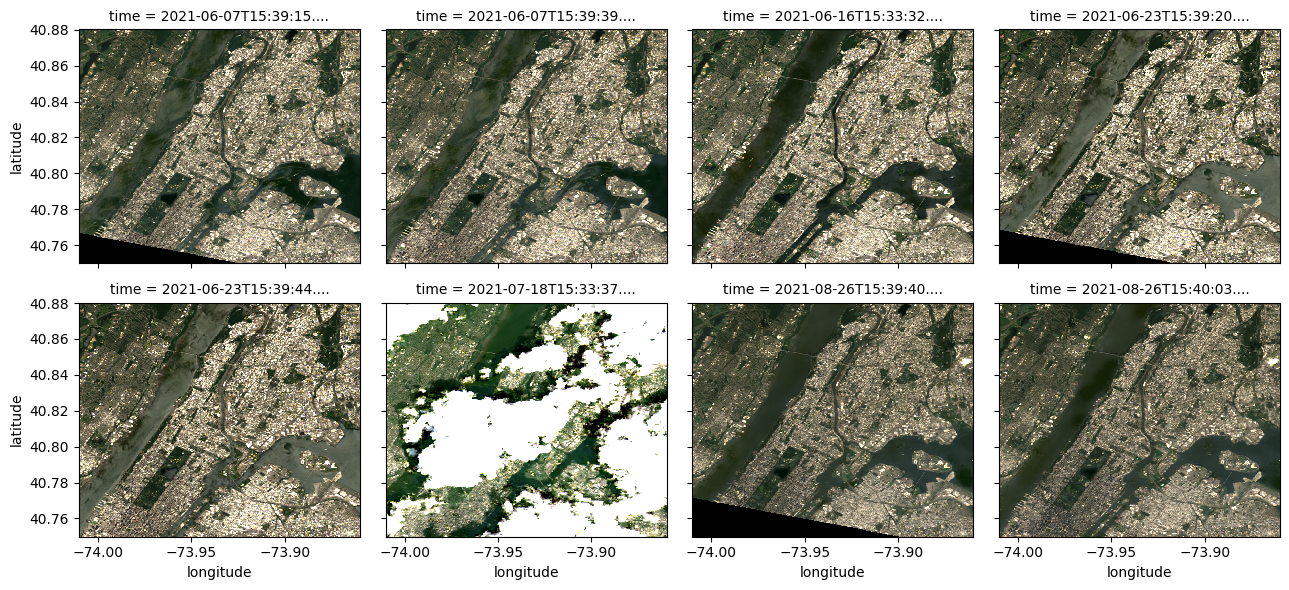

In [46]:
plot_data = data1[["red","green","blue"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.25)
plt.show()

In [47]:
# def create_cloud_mask(qa_pixel):
#     """
#     Create a cloud mask from the QA_PIXEL band of Landsat-8.
#     Cloud-related bits: 3, 4, 5, 6, 7.
#     """
#     cloud_mask = (
#         ((qa_pixel & (1 << 3)) == 0) &  # Cloud
#         ((qa_pixel & (1 << 4)) == 0) &  # Cloud Confidence (low)
#         ((qa_pixel & (1 << 5)) == 0) &  # Cloud Confidence (high)
#         ((qa_pixel & (1 << 6)) == 0) &  # Cirrus Cloud
#         ((qa_pixel & (1 << 7)) == 0)    # Cirrus Confidence (high)
#     )
#     return cloud_mask

# # Apply the cloud mask
# weights = create_cloud_mask(data1["qa_pixel"])
# print(weights)

In [48]:
# weighted_mosaic = {}
# total_weights = weights.sum(dim="time") + 1e-10  # Prevent division by zero

# for band in ['red', 'green', 'blue', 'nir08', 'swir16', 'swir22', 'lwir11']:
#     # Allow zero values and normalize by total weights
#     valid_data = (data1[band] * weights).where(data1[band] >= 0)  
#     weighted_mosaic[band] = valid_data.sum(dim="time") / total_weights

# # Convert to xarray Dataset
# weighted_mosaic_data = xr.Dataset(weighted_mosaic)

# # Inspect the final dataset
# for band in weighted_mosaic_data.data_vars:
#     print(f"{band}: Mosaic NaN count: {weighted_mosaic_data[band].isnull().sum().values}, "
#           f"Min: {weighted_mosaic_data[band].min().values}, Max: {weighted_mosaic_data[band].max().values}")

In [49]:
# weighted_mosaic_data["NDVI"] = (
#     (weighted_mosaic_data.nir08 - weighted_mosaic_data.red) /
#     ((weighted_mosaic_data.nir08 + weighted_mosaic_data.red) + 1e-6)
# )

# weighted_mosaic_data["EVI"] = 2.5 * (
#     (weighted_mosaic_data.nir08 - weighted_mosaic_data.red) /
#     (weighted_mosaic_data.nir08 + 6 * weighted_mosaic_data.red - 
#      7.5 * weighted_mosaic_data.blue + 1)
# )

# weighted_mosaic_data["SAVI"] = (
#     ((weighted_mosaic_data.nir08 - weighted_mosaic_data.red) * 1.5) /
#     (weighted_mosaic_data.nir08 + weighted_mosaic_data.red + 0.5)
# )

# weighted_mosaic_data["MSAVI"] = (
#     (2 * weighted_mosaic_data.nir08 + 1 - 
#      ((2 * weighted_mosaic_data.nir08 + 1) ** 2 - 
#       8 * (weighted_mosaic_data.nir08 - weighted_mosaic_data.red)) ** 0.5) / 2
# )

# weighted_mosaic_data["GNDVI"] = (
#     (weighted_mosaic_data.nir08 - weighted_mosaic_data.green) /
#     (weighted_mosaic_data.nir08 + weighted_mosaic_data.green + 1e-6)
# )

# weighted_mosaic_data["NGRDI"] = (
#     (weighted_mosaic_data.green - weighted_mosaic_data.red) /
#     (weighted_mosaic_data.green + weighted_mosaic_data.red + 1e-6)
# )

# # Water-Related Indices
# weighted_mosaic_data["NDWI"] = (
#     (weighted_mosaic_data.green - weighted_mosaic_data.nir08) /
#     (weighted_mosaic_data.green + weighted_mosaic_data.nir08 + 1e-6)
# )

# weighted_mosaic_data["MNDWI"] = (
#     (weighted_mosaic_data.green - weighted_mosaic_data.swir16) /
#     (weighted_mosaic_data.green + weighted_mosaic_data.swir16 + 1e-6)
# )

# weighted_mosaic_data["NDWI_Variant"] = (
#     (weighted_mosaic_data.green - weighted_mosaic_data.swir22) /
#     (weighted_mosaic_data.green + weighted_mosaic_data.swir22 + 1e-6)
# )

# # Soil-Related Indices
# weighted_mosaic_data["BSI"] = (
#     (weighted_mosaic_data.swir16 + weighted_mosaic_data.red - 
#      weighted_mosaic_data.nir08 - weighted_mosaic_data.blue) /
#     (weighted_mosaic_data.swir16 + weighted_mosaic_data.red + 
#      weighted_mosaic_data.nir08 + weighted_mosaic_data.blue + 1e-6)
# )

# weighted_mosaic_data["SBI"] = (
#     (weighted_mosaic_data.red**2 + weighted_mosaic_data.green**2 + 
#      weighted_mosaic_data.swir16**2) ** 0.5
# )

# # Urban/Built-Up Indices
# weighted_mosaic_data["IBI"] = (
#     (2 * weighted_mosaic_data.swir16 - 
#      (weighted_mosaic_data.nir08 + weighted_mosaic_data.red)) /
#     (weighted_mosaic_data.swir16 + weighted_mosaic_data.nir08 + weighted_mosaic_data.red + 1e-6)
# )

# weighted_mosaic_data["UI"] = (
#     (weighted_mosaic_data.nir08 + weighted_mosaic_data.swir16) /
#     (weighted_mosaic_data.red + weighted_mosaic_data.green + 1e-6)
# )

# # Reflectance and Cloud Features
# weighted_mosaic_data["Albedo"] = (
#     (weighted_mosaic_data.red + weighted_mosaic_data.green + 
#      weighted_mosaic_data.blue + weighted_mosaic_data.nir08 + 
#      weighted_mosaic_data.swir16) / 5
# )

# total_weights = weights.sum(dim="time")
# weighted_mosaic_data["Cloud_Percentage"] = xr.where(
#     total_weights > 0,
#     ((~weights).astype(float).sum(dim="time") / total_weights) * 100,
#     0  # Assign 0 where no valid data exists
# )

# # Advanced Features
# weighted_mosaic_data["REP"] = (
#     705 + 35 * (
#         ((weighted_mosaic_data.red + weighted_mosaic_data.swir16) / 2) - 
#         weighted_mosaic_data.nir08
#     ) / (weighted_mosaic_data.swir16 - weighted_mosaic_data.red + 1e-6)
# )
# weighted_mosaic_data["REP"] = weighted_mosaic_data["REP"].clip(min=680, max=750)

# # Save updated mosaic to GeoTIFF
# weighted_mosaic_tiff_path = "Landsat8_WeightedMosaic_With_Indices.tiff"
# weighted_mosaic_data.rio.to_raster(weighted_mosaic_tiff_path, compress="lzw")
# print(f"Weighted mosaic with indices saved at {weighted_mosaic_tiff_path}")

In [50]:
# import rasterio
# import numpy as np

# def inspect_geotiff(file_path):
#     """
#     Opens a GeoTIFF file and inspects each band for min, max, mean, NaN, and Inf values.

#     Parameters:
#     file_path (str): Path to the GeoTIFF file to be inspected.

#     Returns:
#     None
#     """
#     with rasterio.open(file_path) as src:
#         print(f"Inspecting file: {file_path}")
#         print(f"Number of bands: {src.count}")
        
#         for i in range(1, src.count + 1):  # Iterate over bands
#             band_data = src.read(i).astype(float)  # Read band data as float for NaN/Inf checks
            
#             nan_count = np.isnan(band_data).sum()
#             inf_count = np.isinf(band_data).sum()
#             total_pixels = band_data.size
            
#             print(f"Band {i}:")
#             print(f"  Min Value: {np.nanmin(band_data)}")
#             print(f"  Max Value: {np.nanmax(band_data)}")
#             print(f"  Mean Value: {np.nanmean(band_data)}")
#             print(f"  NaN Count: {nan_count}")
#             print(f"  Inf Count: {inf_count}")
#             print(f"  Total Pixels: {total_pixels}")
#             print(f"  NaN Percentage: {100 * nan_count / total_pixels:.2f}%")
#             print(f"  Inf Percentage: {100 * inf_count / total_pixels:.2f}%")
#             print("-" * 40)

# # Path to the saved GeoTIFF file
# file_path = "/kaggle/working/Landsat8_WeightedMosaic_With_Indices.tiff"

# # Inspect the GeoTIFF file
# inspect_geotiff(file_path)